# The material presented in this notebook is for use in Introduction to Deep Learning (ECE 685D) course, Duke University, Fall 2023.

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
train_batch_size = 128
test_batch_size = 100
Num_epoch = 20
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

TrainingData = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
TestingData = torchvision.datasets.MNIST(root='./mnist', train=False, download=True, transform=transform)
TrainingLoader = torch.utils.data.DataLoader(TrainingData, batch_size=train_batch_size, shuffle=True, num_workers=0)
TestingLoader = torch.utils.data.DataLoader(TestingData, batch_size=test_batch_size, shuffle=True, num_workers=0)

# def Array_to_Image(x):
#     x = 0.5*x + 0.5
#     x = x.view(x.size(0), 1, 28, 28)
#     return x

def plot_loss_curves(train_loss_history, test_loss_history, title):
    plt.plot(train_loss_history, label="train", marker="o")
    plt.plot(test_loss_history, label="test", marker="^")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    pass

# Underfitting

## Basic Definition

A model is 'underfit' when it fails to attain satisfactory performance on a learning task.

## Symptoms



*   Training and validation accuracy/performance are roughly equivalent regardless of training time
*   Model exhibits 'mode collapse', in which all predictions are nearly identical regardless of input
*   Training/validation loss curves fail to converge towards a finite value



## Potential Causes

1) Not enough parameters

2) Low Learning Rate

3) High Learning Rate

4) Class Imbalance

5) Vanishing Gradient

6) Batch Size

7) Poor numerical stability / regularization


## Potential Solutions

1) Wider / Deeper Network Architecture

2) Grid search over learning rate

3) Larger batch size

4) Data balancing / augmentation

5) Residual connections

6) Different nonlinear activations

7) Adding regularization terms to objective function(s)

## Basic Example

Note: In this section we will act as if we were training on a single fold of a $k$-fold training paradigm, such that the 'test' data is actually validation data. This assumption allows us to use the 'test' data to formulate our stopping criteria; in the real world, ***if this were a normal train-test split, it would be entirely inappropriate to use the test data for stopping criteria***.

In [8]:
class LeNet5(nn.Module):
    def __init__(self, in_channels=1, hidden1_chans=6, hidden1_kernel_size=5,
                 padding1=2, hidden2_chans=16, hidden2_kernel_size=5, padding2=0,
                 hidden3_features=120, hidden4_features=84, out_classes=10):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=hidden1_chans,
            kernel_size=hidden1_kernel_size,
            stride=1,
            padding=padding1,
            bias=True
        )
        self.conv2 = nn.Conv2d(
            in_channels=hidden1_chans,
            out_channels=hidden2_chans,
            kernel_size=hidden2_kernel_size,
            stride=1,
            padding=padding2,
            bias=True
        )
        self.fc1   = nn.Linear(
            in_features=hidden2_chans*hidden1_kernel_size*hidden2_kernel_size,
            out_features=hidden3_features
        )
        self.fc2   = nn.Linear(in_features=hidden3_features, out_features=hidden4_features)
        self.fc3   = nn.Linear(in_features=hidden4_features, out_features=out_classes)

        self.criterion = nn.CrossEntropyLoss()
        pass

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def fit(self, train_loader, test_loader, model_name, num_epochs=20, lr=1e-3,
            weight_decay=1e-4, stop_criteria=lambda x: x[0]/(x[1]+1)):
        print('Starting training!')
        self = self.to(device)
        best_model_stop_score = 10e+10
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        train_loss_history = []
        test_loss_history = []

        for epoch in range(num_epochs):
            training_loss = 0
            test_loss = 0
            total_train_samples = 0
            total_test_samples = 0

            self.train()
            for batch_ind, (image,label) in enumerate(train_loader):
                image = image.to(device)
                label = label.to(device)
                curr_num_samples_in_batch = image.size(0)
                total_train_samples += curr_num_samples_in_batch

                optimizer.zero_grad()
                predicted_label = self.forward(image)
                loss = self.criterion(predicted_label, label)
                loss.backward()
                optimizer.step()
                training_loss += loss.item()
            training_loss = training_loss/total_train_samples
            print('Epoch: {}, Average Training Loss: {}'.format(epoch, training_loss))
            train_loss_history.append(training_loss)

            self.eval()
            with torch.no_grad():
                for batch_ind, (image,label) in enumerate(test_loader):
                    image = image.to(device)
                    label = label.to(device)
                    curr_num_samples_in_batch = image.size(0)
                    total_test_samples += curr_num_samples_in_batch
                    predicted_label = self.forward(image)
                    loss = self.criterion(predicted_label, label)
                    test_loss += loss.item()
            test_loss = test_loss/total_test_samples
            print('Epoch: {}, Average Test Loss: {}'.format(epoch, test_loss))
            test_loss_history.append(test_loss)

            # again, we assume the test_loader actually contains validation data, otherwise we could not use the test_loss for stop criteria
            if stop_criteria([test_loss,batch_ind]) < best_model_stop_score:
                torch.save(self.state_dict(), 'ckpt_model.pth')
                best_model_stop_score = stop_criteria([training_loss,batch_ind])

        plot_loss_curves(train_loss_history, test_loss_history, model_name)
        print('Done training!')
        return train_loss_history, test_loss_history

Starting training!
Epoch: 0, Average Training Loss: 0.0026938617396789293
Epoch: 0, Average Test Loss: 0.00099409336540848
Epoch: 1, Average Training Loss: 0.0006437791223172099
Epoch: 1, Average Test Loss: 0.0005795610842294991
Epoch: 2, Average Training Loss: 0.000459248797618784
Epoch: 2, Average Test Loss: 0.0004142247066367418
Epoch: 3, Average Training Loss: 0.00034887165032171954
Epoch: 3, Average Test Loss: 0.00036435734536498785
Epoch: 4, Average Training Loss: 0.00030017922271508723
Epoch: 4, Average Test Loss: 0.00033511427538469434
Epoch: 5, Average Training Loss: 0.00025499168140425657
Epoch: 5, Average Test Loss: 0.0003237076566088945
Epoch: 6, Average Training Loss: 0.00022978738676368568
Epoch: 6, Average Test Loss: 0.00026488204295164905
Epoch: 7, Average Training Loss: 0.00018045784993252407
Epoch: 7, Average Test Loss: 0.0002758032507583266
Epoch: 8, Average Training Loss: 0.00016755683285106594
Epoch: 8, Average Test Loss: 0.00035617692650994286
Epoch: 9, Average Tr

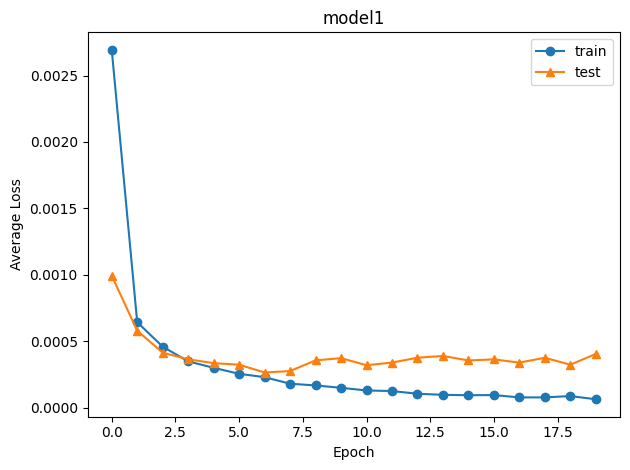

Done training!


In [9]:
model1 = LeNet5(
    in_channels=1,
    hidden1_chans=6,
    hidden1_kernel_size=5,
    padding1=2,
    hidden2_chans=16,
    hidden2_kernel_size=5,
    padding2=0,
    hidden3_features=120,
    hidden4_features=84,
    out_classes=10
)
_,_ = model1.fit(
    TrainingLoader,
    TestingLoader,
    "model1",
    num_epochs=20,
    lr=1e-3,
    weight_decay=1e-4,
    stop_criteria=lambda x: x[0]/(x[1]+1)
)

Starting training!
Epoch: 0, Average Training Loss: 0.017453026362260184
Epoch: 0, Average Test Loss: 0.005904691034555435
Epoch: 1, Average Training Loss: 0.004772059008727471
Epoch: 1, Average Test Loss: 0.004894992800056935
Epoch: 2, Average Training Loss: 0.006274888947606087
Epoch: 2, Average Test Loss: 0.014919314575195313
Epoch: 3, Average Training Loss: 0.0067494142264127735
Epoch: 3, Average Test Loss: 0.0064546171337366105
Epoch: 4, Average Training Loss: 0.00570848236978054
Epoch: 4, Average Test Loss: 0.0058325298696756366
Epoch: 5, Average Training Loss: 0.0073919263109564785
Epoch: 5, Average Test Loss: 0.01162137559056282
Epoch: 6, Average Training Loss: 0.00997924370666345
Epoch: 6, Average Test Loss: 0.010996439164876939
Epoch: 7, Average Training Loss: 0.00743015365699927
Epoch: 7, Average Test Loss: 0.007885864853858948
Epoch: 8, Average Training Loss: 0.012382720056176185
Epoch: 8, Average Test Loss: 0.014999835669994355
Epoch: 9, Average Training Loss: 0.0112974324

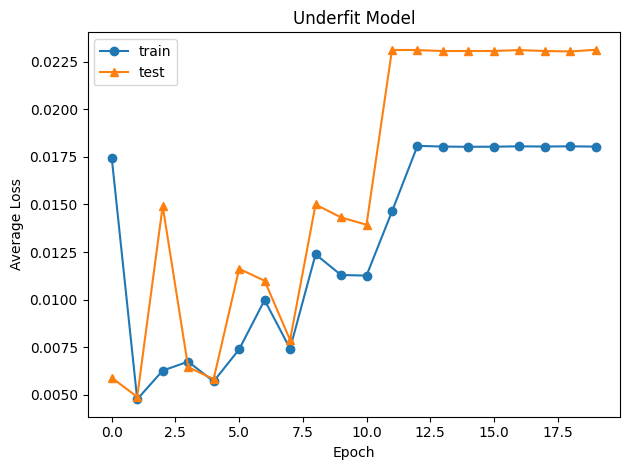

Done training!


In [10]:
model_under = LeNet5(
    in_channels=1,
    hidden1_chans=6,
    hidden1_kernel_size=5,
    padding1=2,
    hidden2_chans=16,
    hidden2_kernel_size=5,
    padding2=0,
    hidden3_features=120,
    hidden4_features=84,
    out_classes=10
)
_,_ = model_under.fit(
    TrainingLoader,
    TestingLoader,
    "Underfit Model",
    num_epochs=20,
    lr=1e-1,
    weight_decay=1e-4,
    stop_criteria=lambda x: x[0]/(x[1]+1)
)

# Overfitting

## Basic Definition

A machine learning model is 'overfit' to its training data if it fails to generalize to novel data samples drawn from the same distribution as the original training data.

## Symptoms

## Potential Causes

1) Too many parameters

2) Training for too long

3) Highly standardized / normalized training images

4) Class Imbalance / Error in train/test split

5) Limited Training Data

-*-

*** Fixed/frozen random seeds

## Potential Solutions

1) Stopping Criteria

2) Reduction in width/depth of network

3) Data augmentation

4) $k$-folds Cross Validation

5) Bagging

6) Dropout

## Basic Example

Starting training!
Epoch: 0, Average Training Loss: 0.0018290222169210512
Epoch: 0, Average Test Loss: 0.0005899073985405266
Epoch: 1, Average Training Loss: 0.0004329015435030063
Epoch: 1, Average Test Loss: 0.00040001957379281523
Epoch: 2, Average Training Loss: 0.0002910163318486108
Epoch: 2, Average Test Loss: 0.00035504394574090837
Epoch: 3, Average Training Loss: 0.0002294847589218989
Epoch: 3, Average Test Loss: 0.00031847322180401537
Epoch: 4, Average Training Loss: 0.0001874068258718277
Epoch: 4, Average Test Loss: 0.0003181324072938878
Epoch: 5, Average Training Loss: 0.0001694051721948199
Epoch: 5, Average Test Loss: 0.00031855042899260296
Epoch: 6, Average Training Loss: 0.00014001311223206964
Epoch: 6, Average Test Loss: 0.0002414815998810809
Epoch: 7, Average Training Loss: 0.00012339282752363943
Epoch: 7, Average Test Loss: 0.0003629396081669256
Epoch: 8, Average Training Loss: 0.00011728820480432963
Epoch: 8, Average Test Loss: 0.00027175785503932273
Epoch: 9, Average T

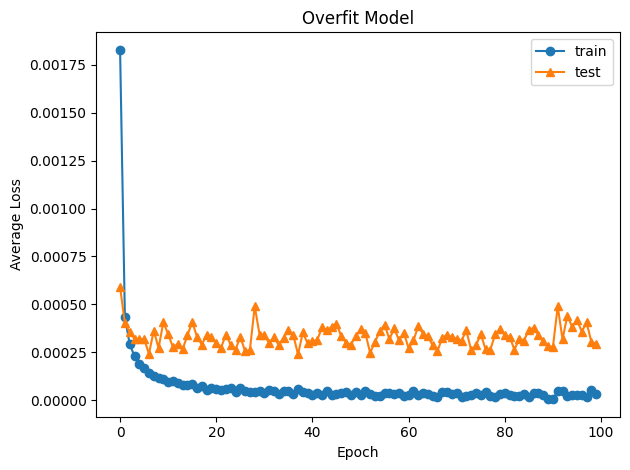

Done training!


In [12]:
model_over = LeNet5(
    in_channels=1,
    hidden1_chans=12,
    hidden1_kernel_size=5,
    padding1=2,
    hidden2_chans=32,
    hidden2_kernel_size=5,
    padding2=0,
    hidden3_features=240,
    hidden4_features=170,
    out_classes=10
)
_,_ = model_over.fit(
    TrainingLoader,
    TestingLoader,
    "Overfit Model",
    num_epochs=100,
    lr=1e-3,
    weight_decay=1e-4,
    stop_criteria=lambda x: x[0]/(x[1]+1)
)

Starting training!
Epoch: 0, Average Training Loss: 0.0018324823771603406
Epoch: 0, Average Test Loss: 0.0005987347302492708
Epoch: 1, Average Training Loss: 0.00044045599030020336
Epoch: 1, Average Test Loss: 0.00046737937396392225
Epoch: 2, Average Training Loss: 0.0003098399946388478
Epoch: 2, Average Test Loss: 0.0003879458030103706
Epoch: 3, Average Training Loss: 0.00023660840562176114
Epoch: 3, Average Test Loss: 0.0003285652851918712
Epoch: 4, Average Training Loss: 0.00019700731204551025
Epoch: 4, Average Test Loss: 0.0002918501341540832
Epoch: 5, Average Training Loss: 0.00015295279146472845
Epoch: 5, Average Test Loss: 0.00033588169822469356
Epoch: 6, Average Training Loss: 0.00012403398972552775
Epoch: 6, Average Test Loss: 0.00029615507302441983
Epoch: 7, Average Training Loss: 0.00010724766585869171
Epoch: 7, Average Test Loss: 0.0002306556774317869
Epoch: 8, Average Training Loss: 8.832200535046771e-05
Epoch: 8, Average Test Loss: 0.00036342675260093527
Epoch: 9, Average

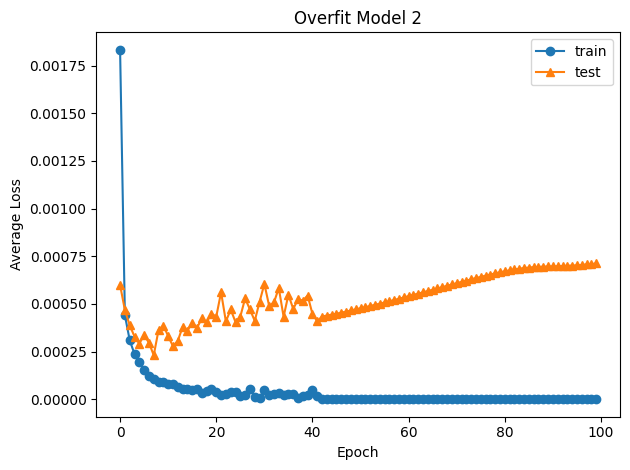

Done training!


In [61]:
model_over2 = LeNet5(
    in_channels=1,
    hidden1_chans=12,
    hidden1_kernel_size=5,
    padding1=2,
    hidden2_chans=32,
    hidden2_kernel_size=5,
    padding2=0,
    hidden3_features=240,
    hidden4_features=170,
    out_classes=10
)
_,_ = model_over2.fit(
    TrainingLoader,
    TestingLoader,
    "Overfit Model 2",
    num_epochs=100,
    lr=1e-3,
    weight_decay=0.,
    stop_criteria=lambda x: x[0]/(x[1]+1)
)

# Bagging

References:

Srihari, S. (2023). Dropout. CSE676 Deep Learning. <https://cedar.buffalo.edu/~srihari/CSE676/7.12%20Dropout.pdf>

**Definition**: Bagging is a regularization approach in which $N$ independent models $f_n(x)$ are trained from the same pool of samples (randomly drawn with replacement) and then vote at test time to produce a final prediction. Voting is typically done via arithmetic mean, i.e.

$$f(x) = \frac{1}{N}\sum_{n=1}^N f_n(x) = \hat{x}$$

**Challenges**:
As models and datasets become increasingly large and complex, classical bagging can become prohibitively expensive

# Dropout

**References**:

Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a simple way to prevent neural networks from overfitting. The journal of machine learning research, 15(1), 1929-1958.
 - (see full paper at <https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf?utm_content=buffer79b43&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer,>)

Srihari, S. (2023). Dropout. CSE676 Deep Learning. <https://cedar.buffalo.edu/~srihari/CSE676/7.12%20Dropout.pdf>


**Dropout as Pseudo-Bagging**: Dropout gets around the $O(N)$ complexity of classical bagging by forcing all models in the ensemble to draw (with replacement) from the same set of parameters in addition to the training data. This enables exponentially many models to be trained with a fixed memory cost. Since parameters (and hence, models) are randomly sampled during training, voting is performed at test time by weighting the output (i.e. 'vote') of each parameter by its probability of being sampled during training.

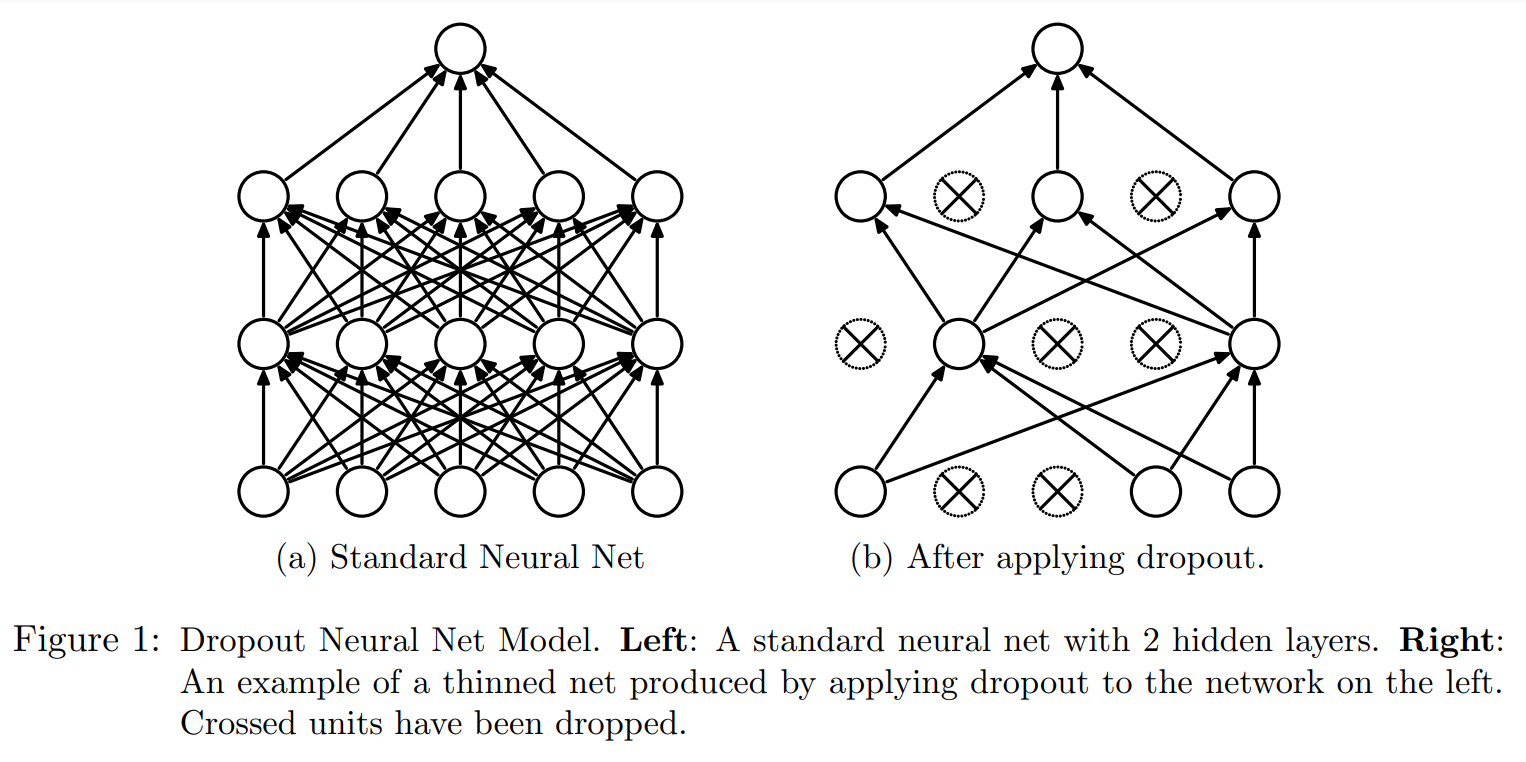

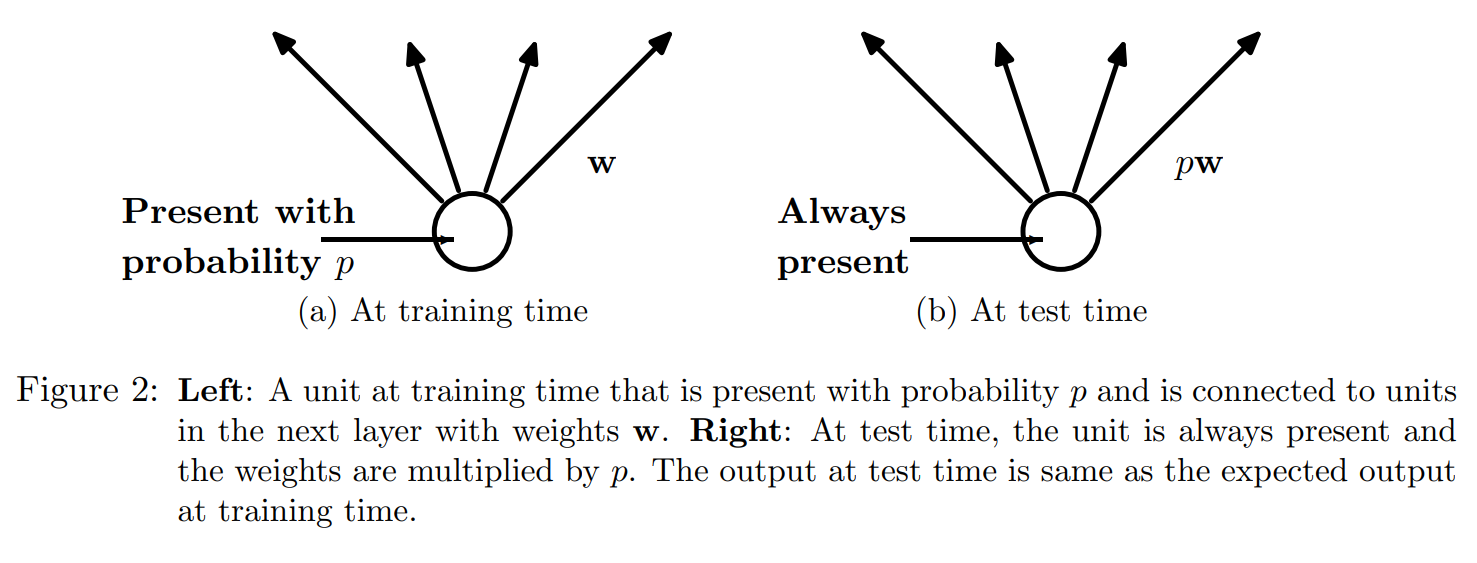

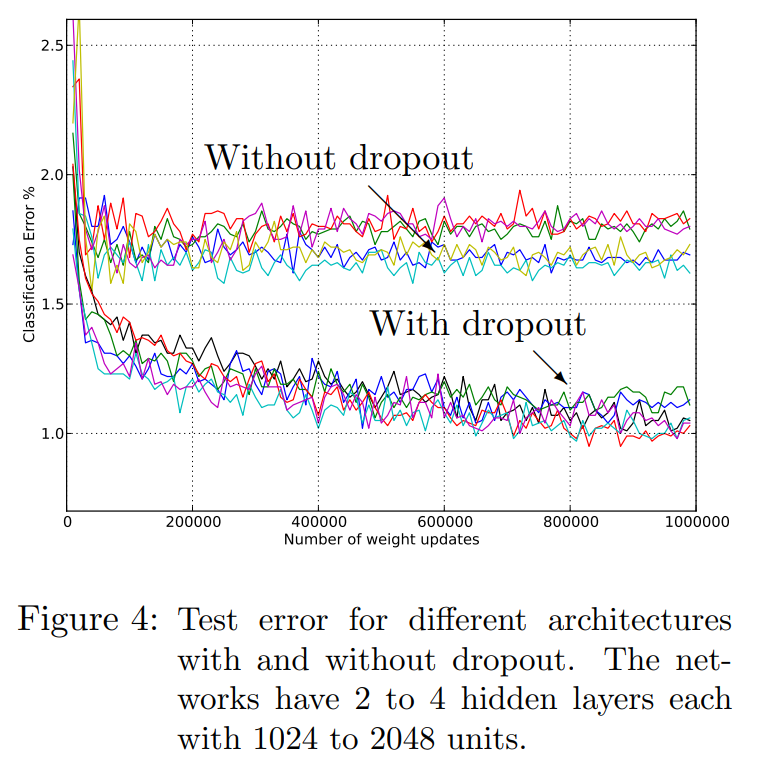

## Example Implementation: AlexNet from Lab 4

In [13]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: 1000, dropout: 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout), # the dropout mask is called before the layer to which dropout is applied
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


## Final Note

Remember to switch between dropout modes of ``` torch.nn.Dropout() ``` using the ``` model.train() ``` and ``` model.eval() ``` commands.



# Notes and Further Reading

## Double-Descent

**Resource**:

Belkin, M., Hsu, D., Ma, S., & Mandal, S. (2019). Reconciling modern machine-learning practice and the classical bias–variance trade-off. Proceedings of the National Academy of Sciences, 116(32), 15849-15854.

(See paper at <https://www.pnas.org/doi/epdf/10.1073/pnas.1903070116>)

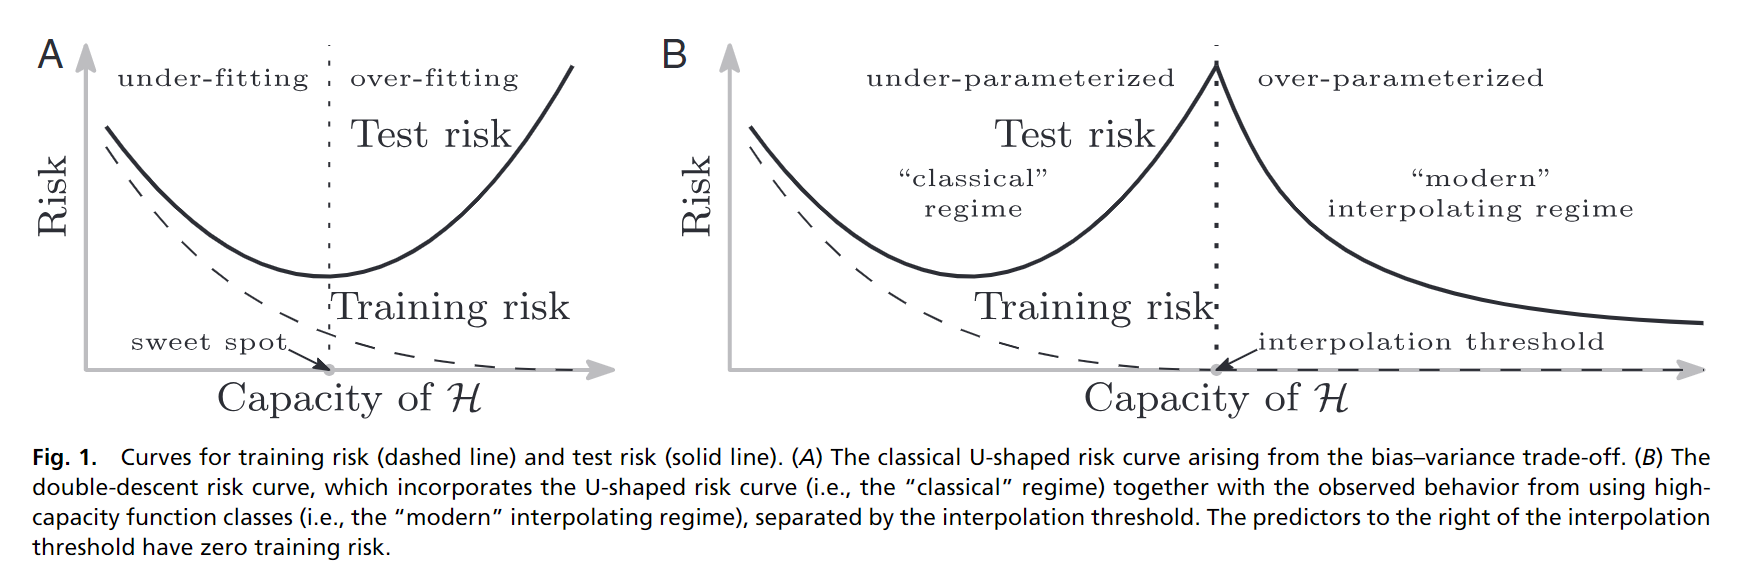

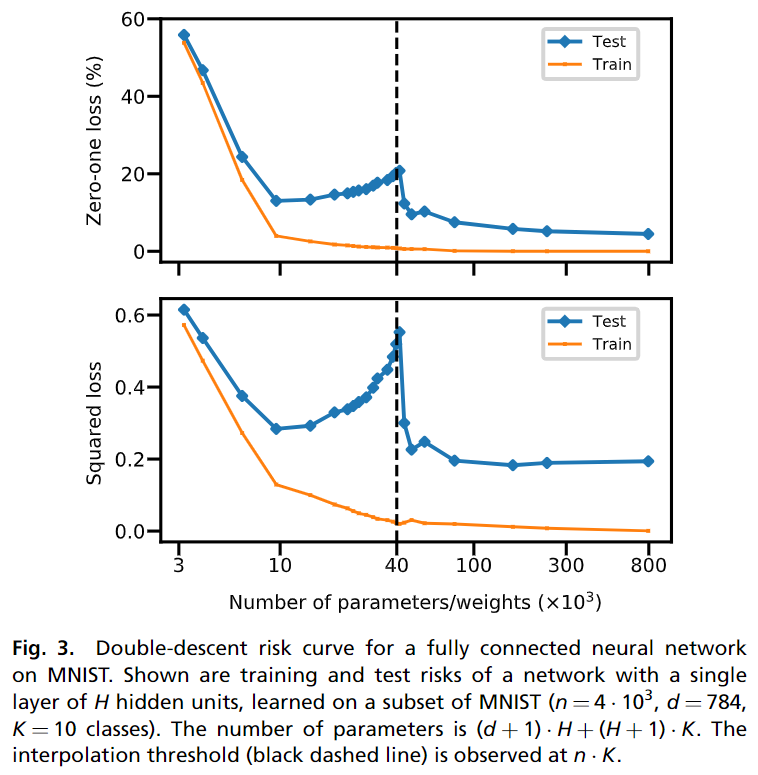

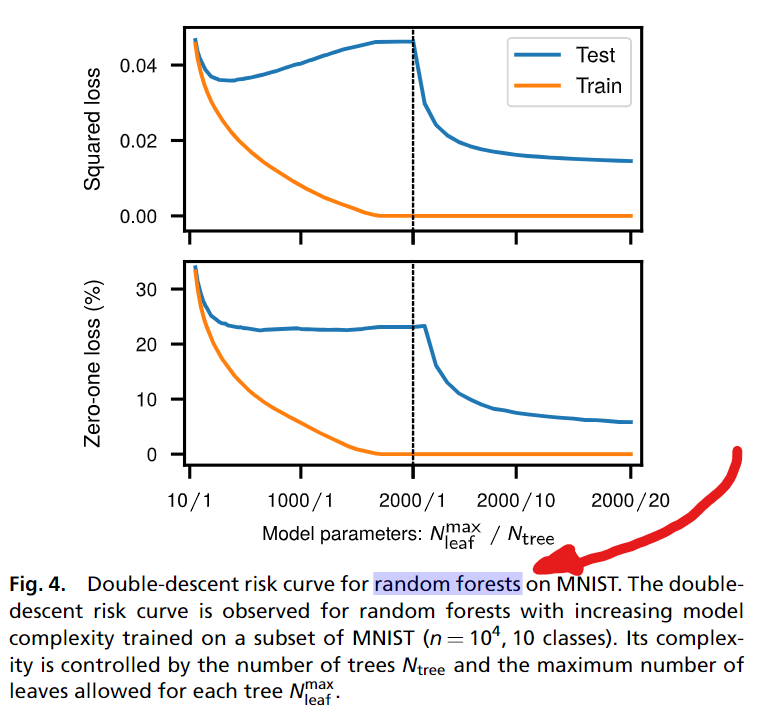